In [16]:
from datetime import datetime
import os

import numpy as np
import pandas as pd
from scipy.stats import qmc
from scipy.optimize import minimize

import torch

import scienceplots

import matplotlib.pyplot as plt
import matplotlib as mp
plt.style.use(['science', 'notebook', 'grid'])

# Then set custom font configurations
FONTSIZE = 20
font = {
    'family': 'serif',
    'weight': 'normal',
    'size': FONTSIZE
}
mp.rc('font', **font)

# Additional configurations
# plt.rcParams['lines.linewidth'] = 5
mp.rc('text', usetex=False)


# set usetex = False if LaTex is not
# available on your system or if the
# rendering is too slow

import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm

import importlib

from configs import *
import acquisition_funcs
importlib.reload(acquisition_funcs)
from acquisition_funcs import *
from objective_funcs import pythia_objective_func
import BayesOpt_utils
importlib.reload(BayesOpt_utils)
from BayesOpt_utils import *



In [17]:

PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,10.0],
        'StringFlav:ProbStoUD':[0,1.0],
        'StringFlav:probQQtoQ':[0,1.0],
        # 'StringFlav:probSQtoQQ':[0,1.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,1.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]
}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    # "rFactC": 1.32,
    # "rFactB":0.855,
    # "aExtraSQuark": 0.0,
    # "aExtraDiquark":0.97,
    # "sigma":0.335,
    # "enhancedFraction":0.01,
    # "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    # "probSQtoQQ":0.915,
    # "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

param_names = list(PARAM_DICT.keys())
num_params = len(param_names)
POINT2 = {key:0.5*value for key, value in MONASH_DICT.items()}
POINT3 = {key:1.5*value for key, value in MONASH_DICT.items()}

NUM_PYTHIA_EVENTS=250000
# NUM_PYTHIA_EVENTS=1000
#250000, 1000
KERNEL = 'Matern'
NUM_TRAIN_POINTS=25
N_TRAIN_EPOCHS=100
N_BO_ITERATIONS = 70# num_params * 30
#N_BO_ITERATIONS = 2
N_OPTIMIZE_ACQ_ITER = 50
N_RESTARTS = 25
# OPTIMIZE_ACQ_METHOD: ['GD', 'Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'
KAPPA=-1E-5

# plot regrets of $f_{pythia}$

num_params=6
path_name=/home/ali/Pulled_git_repositories/BayesOptPythia/BayesOpt/output/pythia_objective_func_N_BO_ITERATIONS_80_N_TRAIN_POINTS_25_N_PARAMS_6_N_OPTIMIZE_ACQ_ITER_50_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000


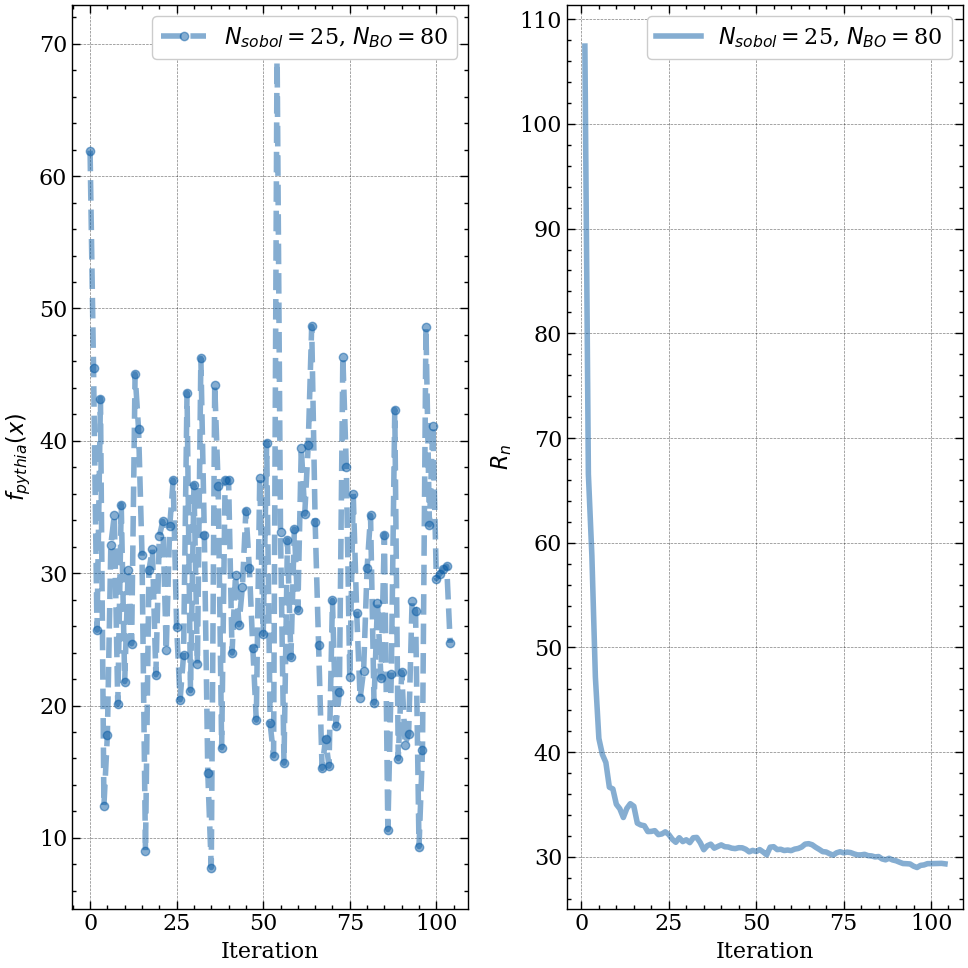

In [22]:
object_func = pythia_objective_func

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')
n_bo_iterations_l = [80]
n_train_points_l = [25,]
for n_bo_iterations, n_train_points in zip(n_bo_iterations_l, n_train_points_l):
    hyper_params_dict = {
    'N_BO_ITERATIONS': n_bo_iterations,
    'N_TRAIN_POINTS': n_train_points,
    'N_PARAMS': num_params,
    'N_OPTIMIZE_ACQ_ITER': N_OPTIMIZE_ACQ_ITER,
    'N_RESTARTS': N_RESTARTS,
    'KERNEL': KERNEL,
    'OPTIMIZE_ACQ_METHOD': OPTIMIZE_ACQ_METHOD,
    'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
    }

    _, config_string = configs_df(hyper_params_dict)

    dir_name = directory_name(object_func, hyper_params_dict)
    # print(f'dir_name={dir_name}')
    path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
    print(f'path_name={path_name}')
    history_df = load_history_df(path_name)
    iterations = np.arange(len(history_df))

    fig, ax = plt.subplots(1,2,figsize=(10,10))
    label_string = r'$N_{sobol}=$'+str(n_train_points)+r', $N_{BO}=$'+str(n_bo_iterations)

    ax[0].plot(iterations, history_df['chi2'],'o--', linewidth=4, alpha=0.5,
               label=label_string)
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel(r'$f_{pythia}(x)$')
    ax[0].legend()
    cum_regret = (history_df['chi2']).cumsum()/iterations
    ax[1].plot(iterations, cum_regret, label=label_string,linewidth=4, alpha=0.5)
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel(r'$R_n$')
    ax[1].legend()
    # ax[1].set_title(r'$R_n$')
plt.tight_layout()

# PYTHIA RESUTLS TABLE (Gpytorch)


In [5]:
results_df = pd.DataFrame()
for run_ind, dirs in enumerate(os.listdir(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output'))):
    if 'pythia' in dirs:
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dirs)
        hyper_params_df = pd.read_csv(os.path.join(path_name, 'configs.csv'))

        best_params_df = pd.read_csv(os.path.join(path_name, 'best_params.csv'))


        row_dict = {
            '$N_{\\text{BO}}$': hyper_params_df['N_BO_ITERATIONS'].iloc[0],
            '$N_{\\text{sobol}}$': hyper_params_df['N_TRAIN_POINTS'].iloc[0], 
            # '$N_{\\text{params}}$': hyper_params_df['N_PARAMS'].iloc[0],
            '$E_{\\text{opt}}$': hyper_params_df['N_OPTIMIZE_ACQ_ITER'].iloc[0],
            # '$N_{\\text{restarts}}$': hyper_params_df['N_RESTARTS'].iloc[0],
            # '$N_{\\text{pythia}}$': hyper_params_df['NUM_PYTHIA_EVENTS'].iloc[0],
            '$f_\\text{best}$': best_params_df['best_f'].iloc[0],
            'aLund': best_params_df['aLund'].iloc[0],
            'bLund': best_params_df['bLund'].iloc[0],
            'ProbStoUD': best_params_df['ProbStoUD'].iloc[0],
            'probQQtoQ': best_params_df['probQQtoQ'].iloc[0],
            'alphaSvalue': best_params_df['alphaSvalue'].iloc[0],
            'pTmin': best_params_df['pTmin'].iloc[0],

        }
        results_df = pd.concat([results_df, pd.DataFrame(row_dict, index=[run_ind])])
# print(results_df)
results_df = results_df.sort_values(by='$N_{\\text{BO}}$')
print(results_df)
# pythia_results_df = results_df.to_latex(buf=os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output','post_processing', 'pythia_results.tex'),index=False,float_format="%.3f")   
# print(pythia_results_df)      

FileNotFoundError: [Errno 2] No such file or directory: '/home/ali/Pulled_git_repositories/BayesOptPythia/BayesOpt/output/BOTorch_pythia_N_TRAIN_POINTS_25_N_BO_ITERATIONS_60_N_PYTHIA_EVENTS_250000/configs.csv'

In [33]:
print(pythia_results_df)   

None


# PYTHIA RESUTLS TABLE (BOTorch)



In [44]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
from scipy.optimize import minimize

import torch

import matplotlib.pyplot as plt
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
import matplotlib as mp
mp.rc('font', **font)

# set usetex = False if LaTex is not
# available on your system or if the
# rendering is too slow
mp.rc('text', usetex=False)


import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.distributions import MultivariateNormal

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
import botorch
botorch.settings.debug(True)


#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm

from typing import Optional
from torch import Tensor


from BayesOpt_utils import *
from objective_funcs import *
from acquisition_funcs import *
from models import * 
from plotting import *
BAYESOPT_BASE=os.environ['BAYESOPT_BASE']



[WARNING 12-06 11:28:51] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [62]:
N_TRAIN_POINTS = 15

n_bo_iterations_l = [20, 40, 60]
BO_results_df_15 = pd.DataFrame()

for run_ind, n_bo_iterations in enumerate(n_bo_iterations_l):
    BO_dir_string = f'BOTorch_pythia_N_TRAIN_POINTS_{N_TRAIN_POINTS}_N_BO_ITERATIONS_{n_bo_iterations}_N_PYTHIA_EVENTS_{NUM_PYTHIA_EVENTS}'
    BO_dir = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', BO_dir_string)
    best_params_df = pd.read_csv(os.path.join(BO_dir, 'best_parameters.csv'))
    # print(best_params_df)
    history_df = pd.read_csv(os.path.join(BO_dir, 'history.csv'))
    f_best_ind = history_df['pythia_objective_func'].argmin()
    f_best = history_df['pythia_objective_func'].iloc[f_best_ind]
    alphaSvalue_best = history_df['alphaSvalue'].iloc[f_best_ind]
    print(f'alphaSvalue_best={alphaSvalue_best}')
    row_dict = {
        '$N_{\\text{BO}}$': n_bo_iterations,
        '$N_{\\text{sobol}}$': N_TRAIN_POINTS, 
        # '$N_{\\text{params}}$': hyper_params_df['N_PARAMS'].iloc[0],
        # '$N_{\\text{restarts}}$': hyper_params_df['N_RESTARTS'].iloc[0],
        # '$N_{\\text{pythia}}$': hyper_params_df['NUM_PYTHIA_EVENTS'].iloc[0],
        '$f_\\text{best}$': f_best,
        'aLund': best_params_df['aLund'].iloc[0],
        'bLund': best_params_df['bLund'].iloc[0],
        'ProbStoUD': best_params_df['ProbStoUD'].iloc[0],
        'probQQtoQ': best_params_df['probQQtoQ'].iloc[0],
        'alphaSvalue': best_params_df['alphaSvalue'].iloc[0],
        'pTmin': best_params_df['pTmin'].iloc[0],
    }
    BO_results_df_15 = pd.concat([BO_results_df_15, pd.DataFrame(row_dict, index=[run_ind])])

BO_results_df_15 = BO_results_df_15.sort_values(by='$N_{\\text{BO}}$')


alphaSvalue_best=0.1403826303581297
alphaSvalue_best=0.1358914980023327
alphaSvalue_best=0.1405668232363276


In [63]:
print(BO_results_df_15)

   $N_{\text{BO}}$  $N_{\text{sobol}}$  $f_\text{best}$     aLund     bLund  \
0               20                  15       856.565212  2.000000  2.000000   
1               40                  15       290.901151  1.207251  1.727632   
2               60                  15       624.862116  2.000000  1.577711   

   ProbStoUD  probQQtoQ  alphaSvalue     pTmin  
0   0.868011   0.166987     0.143174  0.528286  
1   0.980267   0.000000     0.135891  0.565291  
2   0.000000   0.554784     0.140567  0.100000  


In [64]:
N_TRAIN_POINTS = 25

n_bo_iterations_l = [80,90]
BO_results_df_25 = pd.DataFrame()

for run_ind, n_bo_iterations in enumerate(n_bo_iterations_l):
    BO_dir_string = f'BOTorch_pythia_N_TRAIN_POINTS_{N_TRAIN_POINTS}_N_BO_ITERATIONS_{n_bo_iterations}_N_PYTHIA_EVENTS_{NUM_PYTHIA_EVENTS}'
    BO_dir = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', BO_dir_string)
    best_params_df = pd.read_csv(os.path.join(BO_dir, 'best_parameters.csv'))
    # print(best_params_df)
    history_df = pd.read_csv(os.path.join(BO_dir, 'history.csv'))
    f_best_ind = history_df['pythia_objective_func'].argmin()
    f_best = history_df['pythia_objective_func'].iloc[f_best_ind]
    alphaSvalue_best = history_df['alphaSvalue'].iloc[f_best_ind]
    print(f'alphaSvalue_best={alphaSvalue_best}')
    row_dict = {
        '$N_{\\text{BO}}$': n_bo_iterations,
        '$N_{\\text{sobol}}$': N_TRAIN_POINTS, 
        # '$N_{\\text{params}}$': hyper_params_df['N_PARAMS'].iloc[0],
        # '$N_{\\text{restarts}}$': hyper_params_df['N_RESTARTS'].iloc[0],
        # '$N_{\\text{pythia}}$': hyper_params_df['NUM_PYTHIA_EVENTS'].iloc[0],
        '$f_\\text{best}$': f_best,
        'aLund': best_params_df['aLund'].iloc[0],
        'bLund': best_params_df['bLund'].iloc[0],
        'ProbStoUD': best_params_df['ProbStoUD'].iloc[0],
        'probQQtoQ': best_params_df['probQQtoQ'].iloc[0],
        'alphaSvalue': best_params_df['alphaSvalue'].iloc[0],
        'pTmin': best_params_df['pTmin'].iloc[0],
    }
    BO_results_df_25 = pd.concat([BO_results_df_25, pd.DataFrame(row_dict, index=[run_ind])])

BO_results_df_25 = BO_results_df_25.sort_values(by='$N_{\\text{BO}}$')
print(BO_results_df_25)

alphaSvalue_best=0.1345958084240555
alphaSvalue_best=0.13578652014056
   $N_{\text{BO}}$  $N_{\text{sobol}}$  $f_\text{best}$     aLund     bLund  \
0               80                  25       479.285243  1.576470  1.764354   
1               90                  25       257.061010  1.157987  1.910960   

   ProbStoUD  probQQtoQ  alphaSvalue     pTmin  
0   0.278662   0.311959     0.142087  0.440404  
1   1.000000   0.000000     0.135787  0.100000  


In [66]:
BO_results_df = pd.concat([BO_results_df_15, BO_results_df_25])
BO_results_df = BO_results_df.sort_values(by='$N_{\\text{BO}}$')
print(BO_results_df)
BOTorch_pythia_results_df = BO_results_df.to_latex(buf=os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output','post_processing', 'BOTorch_pythia_results.tex'),index=False,float_format="%.3f")   


   $N_{\text{BO}}$  $N_{\text{sobol}}$  $f_\text{best}$     aLund     bLund  \
0               20                  15       856.565212  2.000000  2.000000   
1               40                  15       290.901151  1.207251  1.727632   
2               60                  15       624.862116  2.000000  1.577711   
0               80                  25       479.285243  1.576470  1.764354   
1               90                  25       257.061010  1.157987  1.910960   

   ProbStoUD  probQQtoQ  alphaSvalue     pTmin  
0   0.868011   0.166987     0.143174  0.528286  
1   0.980267   0.000000     0.135891  0.565291  
2   0.000000   0.554784     0.140567  0.100000  
0   0.278662   0.311959     0.142087  0.440404  
1   1.000000   0.000000     0.135787  0.100000  
